In [4]:
import os

if os.path.basename(os.getcwd()) != 'biometria2':
    os.chdir(os.path.dirname(os.getcwd()))


In [5]:
from notebooks.experiments_utils import SpeakerDataset
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_dataset = SpeakerDataset('./split_data/train/*/*.wav', device=device)
val_dataset = SpeakerDataset('./split_data/val/*/*.wav', device=device)
test_profile_dataset = SpeakerDataset('./test_users/profile/*/*.wav', device=device)
test_wild_dataset = SpeakerDataset('./test_users/wild/*/*.wav', device=device)

In [6]:
from sklearn.model_selection import train_test_split

# def test_profile_generator(dataset):
#     for profile in dataset:
#         train_part, dev_part = train_test_split(profile, test_size=0.33, random_state=42)
#         yield {'profile': train_part, 'wild': dev_part}


def training_profile_generator(tr_dataset, v_dataset):
    for profile, wild in zip(tr_dataset, v_dataset):
        yield {'profile': profile, 'wild': wild}

In [4]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

test_profiles = [a for a in tqdm(training_profile_generator(test_profile_dataset, 
                                                            test_wild_dataset), 
                                                            total=len(test_profile_dataset))]

100%|██████████| 116/116 [00:18<00:00,  6.32it/s]


In [5]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

training_profiles = [a for a in tqdm(training_profile_generator(train_dataset, val_dataset), total=len(train_dataset))]

100%|██████████| 118/118 [00:29<00:00,  4.04it/s]


In [8]:
from Speaker_Verification.speech_embedder_net import SpeechEmbedder
import torch

embedder_net = SpeechEmbedder().to(device)
embedder_net.load_state_dict(torch.load(os.path.join('.', 
                                                     'speech_id_checkpoint', 
                                                     '2nd',
                                                     'ckpt_epoch_300_batch_id_30.pth')))

<All keys matched successfully>

100%|██████████| 50/50 [02:20<00:00,  2.80s/it]


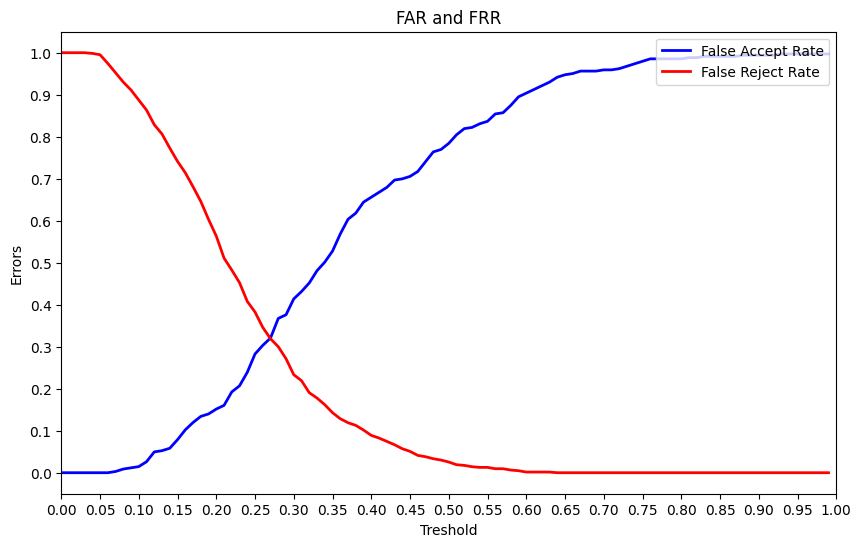

In [7]:
from notebooks.experiments_utils import find_thresh

find_thresh(train_dataset=train_dataset, val_dataset=val_dataset, model=embedder_net)
torch.cuda.empty_cache()

# 0.31

100%|██████████| 50/50 [01:08<00:00,  1.37s/it]


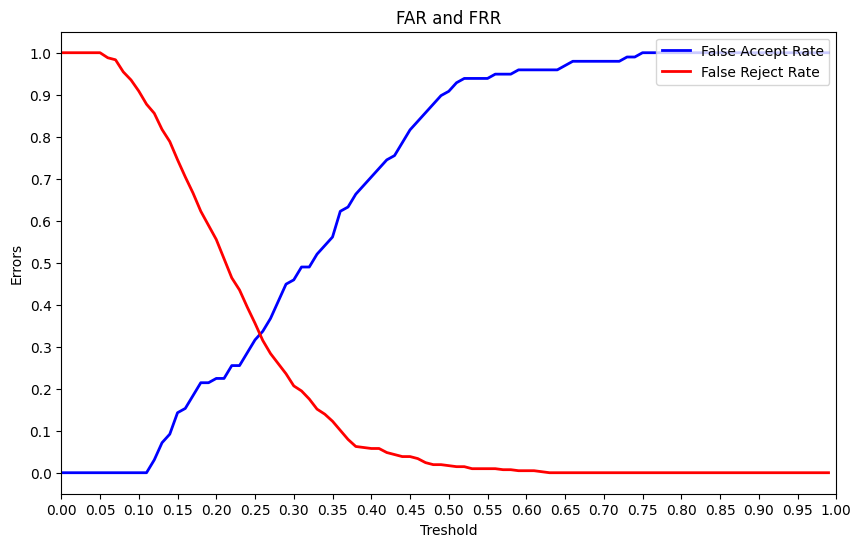

In [8]:
from notebooks.experiments_utils import find_thresh

find_thresh(train_dataset=test_profile_dataset, val_dataset=test_wild_dataset, model=embedder_net)
torch.cuda.empty_cache()


In [9]:
verification_thresh = 0.27

In [15]:
from notebooks.experiments_utils import make_experent

make_experent(verification_thresh, embedder_net(train_dataset[20]), embedder_net(val_dataset[20]))

[1, 0, 0, 1, 1, 0, 1, 0, 1, 1]

In [10]:
import random
def get_random_samples(profiles, ignore_idx, count):

    wrong_images = []
    while len(wrong_images) < count:
        profile_id = random.randint(a=0, b=len(profiles) - 1)
        if profile_id != ignore_idx:
            test_count = len(profiles[profile_id])
            sample_id = random.randint(a=0, b=test_count - 1)
            selected_profile = profiles[profile_id]
            wrong_images.append(selected_profile['wild'][sample_id])
    return torch.stack(wrong_images)

In [12]:
make_experent(0.31, embedder_net(train_dataset[18]), 
              embedder_net(val_dataset[18]))

[1, 1, 1, 1, 1, 1, 1, 1, 1]

In [13]:
id1 = 13
id2 = 13
test_thresh = 0.3

len(test_profiles[id1]['profile']), len(test_profiles[id2]['wild'])

(13, 7)

In [14]:
make_experent(test_thresh, embedder_net(test_profiles[id1]['profile']), 
              embedder_net(test_profiles[id2]['wild']))

[1, 1, 1, 1, 1, 1, 1]

In [15]:
# answer = []

# for emb in test_profiles[id2]['wild']:
#     sim = 1 - torch.nn.functional.cosine_similarity(embedder_net(emb.unsqueeze(0)), 
#                                                 embedder_net(test_profiles[id1]['profile']))
#     sim = (sim <= test_thresh).float()

#     answer.append( 1 if sim.mean(dim=0) > 0.5 else 0)

# answer

In [11]:
import pandas as pd

def results_to_df(list_of_results, indecies):
    return pd.DataFrame(list_of_results, index=indecies)

from tqdm import tqdm
from notebooks.metrics import calculate_general_metrics_from_preds, calc_far_frr
from IPython.display import clear_output

def run_experiment(verification_thresh, tested_profiles):
    all_trues = []
    all_preds = []

    for i, profile in enumerate(tqdm(tested_profiles)):
        test_images = profile['wild']
        test_im_len = len(test_images)
        true_labels = [1] * test_im_len

        test_images = torch.concat([test_images, get_random_samples(tested_profiles, i, test_im_len)], dim=0)
        true_labels += [0] * test_im_len

        pred_labels = make_experent(verification_thresh, 
                                    embedder_net(profile['profile']), 
                                    embedder_net(test_images))

        if len(pred_labels) != len(true_labels):
            raise Exception('Errr')
        
        all_preds += pred_labels
        all_trues += true_labels
        
    TP, FP, TN, FN = calculate_general_metrics_from_preds(actual=all_trues, prediction=all_preds)

    FAR, FRR = calc_far_frr(FP, FN, totalP=TP+FP, totalN=TN+FN)
    
    clear_output(wait=True)
    return{
            'TP': TP,
            'FP': FP,
            'TN': TN,
            'FN': FN,
            'FAR': FAR,
            'FRR': FRR
        }

# Zwykły test weryfikacji

Dane z treningu

In [17]:
results = run_experiment(verification_thresh, training_profiles)
results_to_df(list_of_results=results, indecies=[1])

,TP,FP,TN,FN,FAR,FRR
1,1512,497,1153,138,0.384973,0.068691


Dane poza treningiem

In [18]:
results = run_experiment(verification_thresh, test_profiles)
results_to_df(list_of_results=results, indecies=[1])

,TP,FP,TN,FN,FAR,FRR
1,870,308,721,159,0.35,0.134975


# Dane z psami

In [19]:
mod_dataset_path = 'split_data_barking_city'

mod_val_dataset = SpeakerDataset(f'./{mod_dataset_path}/val/*/*.wav', device=device)
mod_wild_dataset = SpeakerDataset(f'./{mod_dataset_path}/test/wild/*/*.wav', device=device)

mod_training_profiles = [a for a in tqdm(training_profile_generator(train_dataset, 
                                                                    mod_val_dataset), 
                                                                    total=len(train_dataset))]

mod_test_profiles = [a for a in tqdm(training_profile_generator(test_wild_dataset, 
                                                                    mod_wild_dataset), 
                                                                    total=len(mod_wild_dataset))]

100%|██████████| 116/116 [00:19<00:00,  6.00it/s]


Dane z treningu

In [20]:
results = run_experiment(verification_thresh, mod_training_profiles)
results_to_df(list_of_results=results, indecies=[1])

,TP,FP,TN,FN,FAR,FRR
1,1334,541,1109,316,0.379649,0.168533


Dane poza treningiem

In [21]:
results = run_experiment(verification_thresh, mod_test_profiles)
results_to_df(list_of_results=results, indecies=[1])

,TP,FP,TN,FN,FAR,FRR
1,760,323,745,308,0.306743,0.284395


# Szum 1

In [22]:
mod_dataset_path = 'split_data_white_noise_1'

mod_val_dataset = SpeakerDataset(f'./{mod_dataset_path}/val/*/*.wav', device=device)
mod_wild_dataset = SpeakerDataset(f'./{mod_dataset_path}/test/wild/*/*.wav', device=device)

mod_training_profiles = [a for a in tqdm(training_profile_generator(train_dataset, 
                                                                    mod_val_dataset), 
                                                                    total=len(train_dataset))]

mod_test_profiles = [a for a in tqdm(training_profile_generator(test_wild_dataset, 
                                                                    mod_wild_dataset), 
                                                                    total=len(mod_wild_dataset))]

100%|██████████| 116/116 [00:14<00:00,  8.04it/s]


Dane z treningu

In [23]:
results = run_experiment(verification_thresh, mod_training_profiles)
results_to_df(list_of_results=results, indecies=[1])

,TP,FP,TN,FN,FAR,FRR
1,988,433,1217,662,0.230442,0.465869


Dane poza treningiem

In [24]:
results = run_experiment(verification_thresh, mod_test_profiles)
results_to_df(list_of_results=results, indecies=[1])

,TP,FP,TN,FN,FAR,FRR
1,592,290,778,476,0.23126,0.539683


# Szum 3

In [25]:
mod_dataset_path = 'split_data_white_noise_3'

mod_val_dataset = SpeakerDataset(f'./{mod_dataset_path}/val/*/*.wav', device=device)
mod_wild_dataset = SpeakerDataset(f'./{mod_dataset_path}/test/wild/*/*.wav', device=device)

mod_training_profiles = [a for a in tqdm(training_profile_generator(train_dataset, 
                                                                    mod_val_dataset), 
                                                                    total=len(train_dataset))]

mod_test_profiles = [a for a in tqdm(training_profile_generator(test_wild_dataset, 
                                                                    mod_wild_dataset), 
                                                                    total=len(mod_wild_dataset))]

100%|██████████| 116/116 [00:16<00:00,  7.09it/s]


Dane z treningu

In [26]:
results = run_experiment(verification_thresh, mod_training_profiles)
results_to_df(list_of_results=results, indecies=[1])

,TP,FP,TN,FN,FAR,FRR
1,543,181,1469,1107,0.070264,1.529006


Dane poza treningiem

In [27]:
results = run_experiment(verification_thresh, mod_test_profiles)
results_to_df(list_of_results=results, indecies=[1])

,TP,FP,TN,FN,FAR,FRR
1,344,157,911,724,0.096024,1.44511


# Nasze dane

In [16]:
mod_dataset_path = 'nasze'

our_profiles = SpeakerDataset(f'./{mod_dataset_path}/profile/*/*.wav', device=device)
our_wild = SpeakerDataset(f'./{mod_dataset_path}/wild/*/*.wav', device=device)

mod_test_profiles = [a for a in tqdm(training_profile_generator(our_profiles, 
                                                                    our_wild), 
                                                                    total=len(our_profiles))]

100%|██████████| 3/3 [00:00<00:00,  6.67it/s]


In [17]:
results = run_experiment(verification_thresh, mod_test_profiles)
results_to_df(list_of_results=results, indecies=[1])

,TP,FP,TN,FN,FAR,FRR
1,12,6,10,4,0.428571,0.222222


# Nasze dane psiaki

In [26]:
mod_dataset_path = 'nasze_barking_city'

mod_our_wild = SpeakerDataset(f'./{mod_dataset_path}/wild/*/*.wav', device=device)


mod_test_profiles = [a for a in tqdm(training_profile_generator(our_profiles, 
                                                                    mod_our_wild), 
                                                                    total=len(our_profiles))]

100%|██████████| 3/3 [00:00<00:00,  6.05it/s]


In [27]:
results = run_experiment(verification_thresh, mod_test_profiles)
results_to_df(list_of_results=results, indecies=[1])

,TP,FP,TN,FN,FAR,FRR
1,7,7,9,9,0.388889,0.642857


# Nasze dane szum 1

In [28]:
mod_dataset_path = 'nasze_white_noise_1'

mod_our_wild = SpeakerDataset(f'./{mod_dataset_path}/wild/*/*.wav', device=device)


mod_test_profiles = [a for a in tqdm(training_profile_generator(our_profiles, 
                                                                    mod_our_wild), 
                                                                    total=len(our_profiles))]

100%|██████████| 3/3 [00:00<00:00,  6.42it/s]


In [29]:
results = run_experiment(verification_thresh, mod_test_profiles)
results_to_df(list_of_results=results, indecies=[1])

,TP,FP,TN,FN,FAR,FRR
1,9,6,10,7,0.352941,0.466667


# Nasze dane szum 3

In [32]:
mod_dataset_path = 'nasze_white_noise_3'

mod_our_wild = SpeakerDataset(f'./{mod_dataset_path}/wild/*/*.wav', device=device)


mod_test_profiles = [a for a in tqdm(training_profile_generator(our_profiles, 
                                                                    mod_our_wild), 
                                                                    total=len(our_profiles))]

100%|██████████| 3/3 [00:00<00:00,  6.15it/s]


In [33]:
results = run_experiment(verification_thresh, mod_test_profiles)
results_to_df(list_of_results=results, indecies=[1])

,TP,FP,TN,FN,FAR,FRR
1,1,0,16,15,0.0,15.0
